# Filtro automatizado de SPAM en SMS
**Diego León Ortiz**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import warnings as w 
w.filterwarnings('ignore')

### Cargar la data

SMS Spam Collection: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [5]:
messages = [line.strip() for line in open('SMSSpamCollection')]
len(messages)

5574

Esta colección de textos se conoce como corpus. Imprimimos los primeros diez mensajes

In [6]:
for message_no, message in enumerate(messages[:10]):
    print (message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 1

Vamos a entrenar un modelo de clasificación que nos permita identificar si el mensaje de texto es *ham* o *spam*

In [7]:
messages = pd.read_csv('SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### **_Análisis exploratorio_**

In [8]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

¿Qué tan largos son los mensajes?

In [9]:
messages['length'] = messages['message'].apply(lambda text: len(text))
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


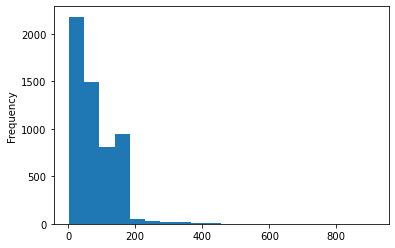

In [10]:
messages.length.plot(bins=20, kind='hist');

In [11]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Hay un mensaje muy largo

In [12]:
print (list(messages.message[messages.length > 900]))

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


In [13]:
print (list(messages[messages.length > 900].index))

[1085]


¿Hay alguna diferencia entre las longitudes de mensajes *ham* y *spam*?

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

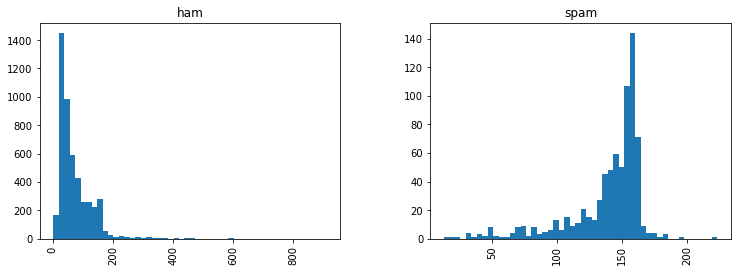

In [14]:
messages.hist(column='length', by='label', bins=50, figsize=(12,4))

### Preprocesamiento

Vamos a convertir cada mensaje en vectores que representen su contenido para poder entrenar el modelo

Los pasos para esto son

1. contar cuantas veces la palabra aparece en el mensaje (term frequency)
2. ponderar las cuentas con la frecuencia de los terminos en los documentos totales
3. normalizar los vectores para obtener el porcentaje que ocupan dentro de cada documento

Para esto utilizamos el vectorizador de sklearn

In [15]:
vectorizer = TfidfVectorizer()
sms_tfidf = vectorizer.fit_transform(messages['message'].values)

print(sms_tfidf.shape)

(5572, 8713)


### Entrenar el modelo

Los métodos de Naive Bayes suelen tener muy buena performance para este tipo de tareas dado que los vectores de features contienen frecuencias
- GaussianNB
- MultinomialNB 
- BernoulliNB

In [16]:
classifier = MultinomialNB()
targets = messages['label'].values
clf = classifier.fit(sms_tfidf, targets)

Clasificamos algunos mensajes para probar el modelo

In [17]:
examples = ['Free entry in 3 a wkly comp', 'Hello my friend']
example_vector = vectorizer.transform(examples)
predictions = classifier.predict(example_vector)

print(predictions)

['spam' 'ham']


### Evaluación de resultados

In [18]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

all_predictions = clf.predict(sms_tfidf)
accuracy = accuracy_score(messages['label'], all_predictions)
cm = confusion_matrix(messages['label'], all_predictions)
statistics = classification_report(messages['label'], all_predictions)

print('Accuracy: %.4f\n' % accuracy)
print(statistics)

Accuracy: 0.9761

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      4825
        spam       1.00      0.82      0.90       747

    accuracy                           0.98      5572
   macro avg       0.99      0.91      0.94      5572
weighted avg       0.98      0.98      0.98      5572



In [ ]:
#recall: de todos los que eran spam, a cuantos detecte

In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
        
    Reference
    -------
    https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print(fig)

Figure(720x504)


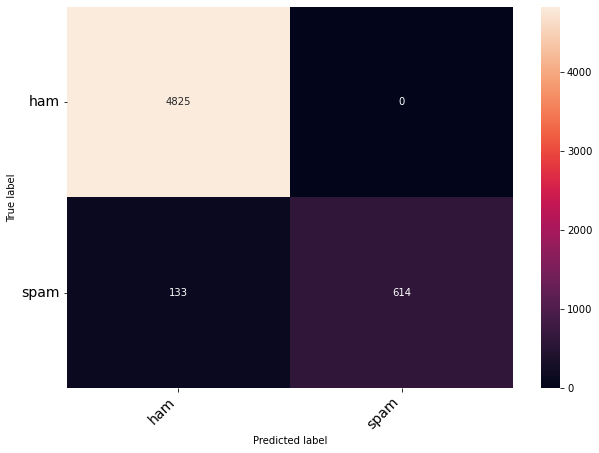

In [20]:
print_confusion_matrix(cm,["ham", "spam"])

#### **_De todos los mensajes que evaluamos como spam, se nos pasaron 133 que resultaron ser spam pero el modelo no los reconoció como tal, otro punto importante es que nuestro modelo no confundió los SMS HAM con SPAM. Es importante conocer el objetivo del negocio para priorizar los resultados._**